# Cube Reprojection and Signal Masking Tutorial

This tutorial shows how to take two spectral cubes observed toward the same part of the sky, but different frequencies, and put them onto the same grid. Then, we use one spectral cube to mask the other, which is helpful for situations where the velocity structure of one cube is more complicated than the other.

## Index 

 * [Step 1: Download](#Step-1:-Download-the-data)
 * [Step 2: Open files, collect metadata](#Step-2:-Load-the-cubes)
 * [Step 3: Convert to velocity](#Step-3:-Convert-cubes-from-frequency-to-velocity)
 * [Step 4: Spectral Interpolation](#Step-4.-Spectral-Interpolation)
 * [Step 5: Spatial Smoothing](#Step-5.-Spatial-Smoothing)
 * [Step 6: Reprojection](#Step-6.-Reprojection)
 * [Step 7: Signal Masking](#Step-7.-Signal-Masking)
 * [Step 8. Moment Maps](#Step-8.-Moment-Maps)
 * [Step 9: Masking Outliers](#Step-9.-Masking-Outliers)
 
In this example, we do spectral smoothing and interpolation (step 4) before spatial smoothing and interpolation (step 5), but if you have a varying-resolution cube (with a different beam size for each channel), you have to do spatial smoothing first.

In [2]:
import pylab as pl
pl.style.use('dark_background')

## Step 1: Download the data

(you might not have to do this step, since you may already have data)

In [3]:
import numpy as np
from astropy.utils.data import download_file

In [4]:
filename_1 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X1465_X3a33.BrickMaser_sci.spw71.cube.I.manual.image.pbcor.fits",
                           cache=True)
filename_1

'/home/abulatek/.astropy/cache/download/url/33718a6f64d8a437fe89bff80278ca22/contents'

In [5]:
filename_2 = download_file("https://almascience.nrao.edu/dataPortal/member.uid___A001_X87d_X141.a_sma1_sci.spw27.cube.I.pbcor.fits",
                          cache=True)
filename_2

'/home/abulatek/.astropy/cache/download/url/391fb3a562ec7b94842f7b6e2a55c67e/contents'

## Step 2: Load the cubes

In [6]:
from spectral_cube import SpectralCube

In [7]:
cube1 = SpectralCube.read(filename_1)
cube1

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: FREQ      unit_s: Hz     range: 139434992275.503 Hz:139503942362.300 Hz

In [8]:
cube2 = SpectralCube.read(filename_2)
cube2

SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: FREQ      unit_s: Hz     range: 216957714464.027 Hz:217190639088.700 Hz

The cubes are at different frequencies - 139 and 89 GHz.

The first cube covers the H2CS 4(1,3)-3(1,2) line at 139.483699	GHz.

The second covers SiO v=5-4 at 217.104984 GHz

In [9]:
cube1.find_lines(chemical_name=' H2CS ').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,H2CS,Thioformaldehyde,--,--,139.48341,0.00028,"4(1,3)-3(1,2)",-3.2185,30.51674,11.223,-4.44732,0.17,16.1465,23.23108,20.79917,29.92519,JPL
1,H2CS,Thioformaldehyde,--,--,139.4836816,5e-05,"4(1,3)-3(1,2)",-3.2182,30.59661,11.251,-4.44619,--,16.1329,23.21151,20.78557,29.90563,CDMS
2,H2CS,Thioformaldehyde,139.483699,1.7e-05,139.483741,2.4e-05,"4(1,3)-3(1,2)",0.0,30.59472,3.75,-3.94426,0.17,16.133,23.21165,20.78568,29.90578,SLAIM
3,H2CS,Thioformaldehyde,139.483699,1.7e-05,--,--,"4(1,3)-3(1,2)",0.0,0.0,0.0,0.0,0.17,0.0,0.0,0.0,0.0,Lovas


In [10]:
cube2.find_lines(chemical_name='SiO').show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Linelist
0,"SiO,v=0-10",Silicon monoxide (global fit),--,--,217.104919,2e-06,"J=5-4,v=0-0",-1.3211,47.9909,0.0,-3.28429,--,14.4843,20.83981,21.72614,31.25927,CDMS
1,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3211,47.99147,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
2,SiOv=0,Silicon Monoxide,--,--,217.10498,5e-05,5-4,-1.3199,47.9911,5.0,-3.28429,1.6,14.4843,20.83956,21.72614,31.25889,CDMS
3,SiOv=0,Silicon Monoxide,--,--,217.10498,8e-05,5-4,-1.3166,48.14651,5.0,-3.28288,1.6,14.4843,20.83956,21.72614,31.25889,JPL
4,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,--,--,5-4,0.0,0.0,0.0,0.0,1.6,0.0,0.0,0.0,0.0,Lovas
5,SiOv=0,Silicon Monoxide,217.104984,1.4e-05,217.10498,0.0001,5-4,0.0,47.6849,5.0,-3.28706,--,14.484,20.83913,21.72584,31.25846,SLAIM


## Step 3: Convert cubes from frequency to velocity

In [11]:
from astropy import units as u

In [12]:
from spectral_cube import SpectralCube
import spectral_cube
spectral_cube.__version__
spectral_cube.__path__

['/blue/adamginsburg/abulatek/spectral-cube/spectral_cube']

In [13]:
cube1vel = cube1.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=139.483699*u.GHz)
cube1vel

SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

In [14]:
cube2vel = cube2.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=217.104984*u.GHz)
cube2vel

SpectralCube with shape=(478, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:    478  type_s: VRAD      unit_s: km / s  range:     -118.278 km / s:     203.359 km / s

From the shape of the cube, we can see the H2CS cube is narrower in velocity, so we'll use that as the target spectral reprojection (otherwise, we would have empty velocity channels on either side of the smaller cube that would be getting reprojected).  However, the SiO cube is the smaller footprint on the sky.

### Do some quicklooks of the peak intensity to see what we expect to see:

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/spectral_cube.py:443: RuntimeWarning: All-NaN slice encountered
  **kwargs)


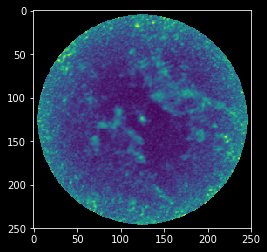

In [15]:
cube1.max(axis=0).quicklook()

/blue/adamginsburg/abulatek/spectral-cube/spectral_cube/spectral_cube.py:443: RuntimeWarning: All-NaN slice encountered
  **kwargs)


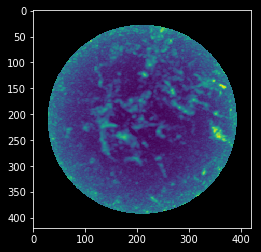

In [16]:
cube2.max(axis=0).quicklook()

# Step 4. Spectral Interpolation

We can do the spatial or spectral step first.  In this case, we choose spectral.

We need to match resolution:

In [17]:
velocity_res_1 = np.diff(cube1vel.spectral_axis)[0]
velocity_res_2 = np.diff(cube2vel.spectral_axis)[0]
velocity_res_1, velocity_res_2

(<Quantity 2.00262828 km / s>, <Quantity 0.67429189 km / s>)

Cube1, our H2CS cube, has broader channels.  We want to smooth cube2 to that channel width before doing the spatial reprojection.

To do this, we'll smooth with a Gaussian with an appropriate FWHM:

In [18]:
fwhm_gaussian = (velocity_res_1**2 - velocity_res_2**2)**0.5
fwhm_gaussian

<Quantity 1.88569628 km / s>

In [19]:
from astropy.convolution import Gaussian1DKernel
fwhm_to_sigma = np.sqrt(8*np.log(2))
# we want the kernel in pixel units, so we force to km/s and take the value
spectral_smoothing_kernel = Gaussian1DKernel(stddev=fwhm_gaussian.to(u.km/u.s).value / fwhm_to_sigma)

Then, let's cut down to the same spectral coverage:

In [20]:
cube2vel_cutout = cube2vel.spectral_slab(cube1vel.spectral_axis.min(), cube1vel.spectral_axis.max())
cube1vel, cube2vel_cutout

(SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(221, 420, 420) and unit=Jy / beam:
  n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
  n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
  n_s:    221  type_s: VRAD      unit_s: km / s  range:      -43.432 km / s:     104.913 km / s)

We then smooth with the kernel.  Note that this is doing 420x420 = 176400 smoothing operations on a length-221 spectrum: it will take a little time

In [21]:
cube2vel_smooth = cube2vel_cutout.spectral_smooth(spectral_smoothing_kernel)

Now that we've done spectral smoothing, we can resample the spectrum:

In [22]:
cube2vel_spectralresample = cube2vel_smooth.spectral_interpolate(cube1vel.spectral_axis)
cube2vel_spectralresample

SpectralCube with shape=(75, 420, 420) and unit=Jy / beam:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

# Step 5. Spatial Smoothing

Now that we've done spectral smoothing, we have to spatially smooth, because we're going to resample the data spatially too

In [23]:
cube1vel.beam, cube2vel_spectralresample.beam

(Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg,
 Beam: BMAJ=0.8935712308515601 arcsec BMIN=0.6649610689789199 arcsec BPA=85.81119797802 deg)

cube1 again has the larger beam, so we'll smooth cube2 to its resolution

#### Aside: mixed beams 

If cube1 and cube2 had different sized beams, but neither was clearly larger, we would have to convolve _both_ to a [common beam](https://radio-beam.readthedocs.io/en/latest/commonbeam.html#finding-the-smallest-common-beam).

In this case, it's redundant and we could have just used cube1's beam, but this is the more general approach:

In [24]:
import radio_beam
common_beam = radio_beam.commonbeam.common_2beams(radio_beam.Beams(beams=[cube1vel.beam, cube2vel.beam]))
common_beam

Beam: BMAJ=1.29719604986604 arcsec BMIN=1.04247149438736 arcsec BPA=82.95313553702 deg

Convert to Kelvin to ensure the units are preserved

In [25]:
cube2vel_spatialspectralsmooth = cube2vel_spectralresample.to(u.K).convolve_to(common_beam)
cube2vel_spatialspectralsmooth

SpectralCube with shape=(75, 420, 420) and unit=K:
 n_x:    420  type_x: RA---SIN  unit_x: deg    range:   266.537002 deg:  266.551600 deg
 n_y:    420  type_y: DEC--SIN  unit_y: deg    range:   -28.711371 deg:  -28.698569 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

# Step 6. Reprojection
Now, finally, we can do the reproject step:

In [26]:
import astropy
print(astropy.__version__)
import reproject
print(reproject.__version__)
# Need development version of astropy
# 4.3.dev1788+ga3263b6 works for me

4.3.dev1788+ga3263b6
0.8.dev31+g9f8ec7b


In [27]:
cube2vel_reproj = cube2vel_spatialspectralsmooth.reproject(cube1vel.header)
cube2vel_reproj 

SpectralCube with shape=(75, 250, 250) and unit=K:
 n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
 n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
 n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s

These two cubes are now on an identical grid, and can be directly compared:

In [28]:
cube2vel_reproj, cube1vel

(SpectralCube with shape=(75, 250, 250) and unit=K:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s,
 SpectralCube with shape=(75, 250, 250) and unit=Jy / beam:
  n_x:    250  type_x: RA---SIN  unit_x: deg    range:   266.534072 deg:  266.554577 deg
  n_y:    250  type_y: DEC--SIN  unit_y: deg    range:   -28.713958 deg:  -28.695975 deg
  n_s:     75  type_s: VRAD      unit_s: km / s  range:      -43.509 km / s:     104.685 km / s)

These spectra can now be overplotted as they are in the same unit with the same beam.

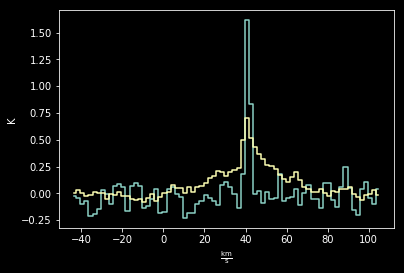

In [29]:
cube1vel[:,125,125].to(u.K).with_spectral_unit(u.km/u.s).quicklook()
cube2vel_reproj[:,125,125].quicklook()

### Do a quick continuum subtraction

In [30]:
med1 = cube1vel.median(axis=0)  
cube1vel = cube1vel - med1
med2 = cube2vel_reproj.median(axis=0)  
cube2vel_reproj = cube2vel_reproj - med2

# Step 7. Signal Masking
Use one of the molecules, H2CS, to mask the other one, SiO.  This can be useful if SiO has complicated multi-component velocity structure, but H2CS a similar morphology on the sky and we want to use that to grab the matching component of the SiO velocity structure.

First, we'll estimate the noise throughout the cube by using a signal-resistant measurement of the standard deviation (called the median absolute deviation (MAD) standard deviation). We'll sigma-clip the cube first at 3 sigma and plot the spectrum to look for where the noise is least affected by signal.

In [31]:
import matplotlib.pyplot as plt

Text(0,0.5,' Noise standard deviation $\\sigma$ (K)')

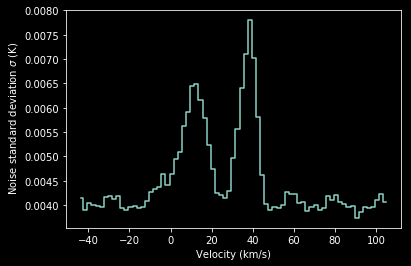

In [32]:
# Make signal mask out of template molecule cube, in noise-free area (should be flat)
cube_sclip = cube1vel.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

We can see that between -15 and 45 km/s, the noise estimate is affected by signal. However, above 60 km/s, the noise is flatter. We'll use this part of the spectrum to estimate the noise map.

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


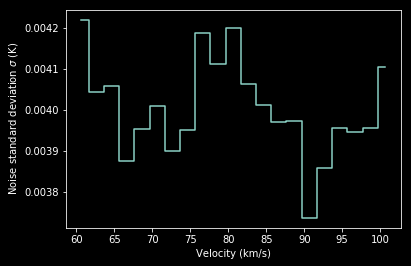

In [33]:
# Calculate noise map based on flat part of spectrum
cube_sclip_cut = cube_sclip.spectral_slab(60*u.km/u.s, 100*u.km/u.s)
mad_std_spectrum_sclip_cut = cube_sclip_cut.mad_std(axis=(1, 2))
plt.plot(mad_std_spectrum_sclip_cut.spectral_axis.value, mad_std_spectrum_sclip_cut.value, 
         drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
mad_std_map_sclip = cube_sclip_cut.mad_std(axis=0) # Calculate sigma along the spectral dimension

Now, we'll create a "plain mask" where we mask the template cube and only keep pixels that are at or above 3 sigma (where sigma is given on a pixel-by-pixel basis by the noise map we just created).

In [34]:
# Calculate and apply plain mask
plain_mask = cube1vel >= 3 * mad_std_map_sclip # Get plain 3sigma mask
plain_masked_slab = cube1vel.with_mask(plain_mask) # Mask the template molecule cube

In [35]:
plain_masked_slab.shape

(75, 250, 250)

Then, we'll apply that mask to the template molecule cube and create a more sophisticated "signal mask" from that cube, which takes into account the fact that connected regions of signal are more likely to be real than an individual high-sigma pixel.

In [36]:
import scipy.ndimage as nd
# Make a low and high mask
low_snr_mask = (plain_masked_slab > 3 * mad_std_map_sclip).include()
high_snr_mask = (plain_masked_slab > 10 * mad_std_map_sclip).include()
# low_snr_mask = low_snr_mask.compute() # Don't need this for this tutorial
# high_snr_mask = high_snr_mask.compute() # Don't need this for this tutorial
# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)
low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
print(f"Initial number of regions found: {num_labels}")
# From the labels, count the number of pixels within each label.
num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels
# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels
# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask
low_min_pixels = 40
high_min_pixels = 10
for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                      num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue
    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)
print(f"Final number of regions found: {num_labels}")
signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)

Initial number of regions found: 11706
Final number of regions found: 7


Finally, we'll apply the signal mask we just created using the template molecule cube (which has a mask at each velocity step) to the target molecule cube.

In [37]:
# Apply signal mask from template molecule to target molecule
masked_cube = cube2vel_reproj.with_mask(signal_mask)
# We can write the masked cube to a file and look at it in DS9, but this is optional:
# masked_cube.write('masked_target_cube.fits', overwrite=True)
# masked_cube = SpectralCube.read('masked_target_cube.fits')

In [38]:
plt.plot(spectrum.spectral_axis, spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')

NameError: name 'spectrum' is not defined

Visualizing the masks:

In [ ]:
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [ ]:
plt.imshow(plain_mask.value)

In [ ]:
plt.imshow(signal_mask.value)

# Step 8. Moment Maps

First, we'll create some initial moment maps of the target molecule using the cube we just masked.

negative vals due to us applying mask to a different cube, noise can be negative

In [ ]:
# Make moment maps from the target cube
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [ ]:
masked_moment1 = masked_cube.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The color bar on the moment 1 map is skewed due to the presence of at least one outlier pixel with a large negative velocity.

# Step 9. Masking Outliers

At the moment, to get a better idea of the velocity structure of the target molecule, we can mask the outliers by masking pixels with a moment 0 value less than some threshold, which can cause moment 1 values to blow up since the moment 0 value appears in the denominator of the moment 1 value.

In [ ]:
# Look for outliers
from pylab import imshow
v_thresh = 1000
masked_moment1 = masked_cube.moment1()
masked_moment1_outliers = (masked_moment1 > v_thresh*u.km/u.s)|(masked_moment1 < -v_thresh*u.km/u.s)
imshow(masked_moment1_outliers, origin='lower') 
# Clumps of outliers might mean they're real, just outside of vel range

In [ ]:
# Look at spectra of outliers individually, can check neighboring spectra here too
max_vel_coord = np.unravel_index(np.nanargmin(masked_moment1), masked_moment1.shape)
spectrum = masked_cube[:, max_vel_coord[0], max_vel_coord[1]]
print(masked_moment1[max_vel_coord[0], max_vel_coord[1]])
plt.plot(spectrum.spectral_axis, spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Intensity (K)')

In [ ]:
# Remove outliers
mom0 = masked_cube.moment0()
mom0_mask = mom0 > 1.*u.K*u.km/u.s # Mask pixels with mom0 less than threshold
print(f"Found {mom0_mask.sum()} good pixels")
masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)

In [ ]:
# Make moment maps from the target cube with outliers removed
masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [ ]:
masked_moment1 = masked_cube_no_outliers.moment1()

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

The velocity structure is more visible here with the outliers removed.

In [ ]:
masked_moment1.write('moment1.fits')

### Addendum: collapse masked cube along spatial axes to make PV projections

In [ ]:
masked_cube_no_outliers.shape # (75, 250, 250)
collapse1 = masked_cube_no_outliers.sum(axis = 1) # Collapse along one spatial axis
collapse2 = masked_cube_no_outliers.sum(axis = 2) # Collapse along the other spatial axis

In [ ]:
imshow(collapse1.value, origin='lower')

In [ ]:
imshow(collapse2.value, origin='lower')